In [17]:
import pandas as pd
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from config import *
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import classification_report
import shap
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
import ast

In [18]:
fakenewsnet = pd.read_csv('../data/fakenewsnet_wf.csv')
isot = pd.read_csv('../data/fn_isot_wf.csv')
fakenewskaggle = pd.read_csv('../data/fn_kaggle_wf.csv')
buzfeed_political = pd.read_csv('../data/fn_buzfeed_wf.csv')
celebrity = pd.read_csv('../data/fn_celebrity_wf.csv')
fakenewsamt = pd.read_csv('../data/fakenewsamt_wf.csv')
fn_randompolitical = pd.read_csv('../data/fn_randompolitical_wf.csv')
 
datasets = {
    'FakeNewsNet' : fakenewsnet,
    'ISOT' : isot,
    'FakeNewsKaggle' : fakenewskaggle,
    'FakeNewsAMT' : fakenewsamt,
    'FakeNewsRandomPolitical' : fn_randompolitical,
    'FakeNewsCelebrity' : celebrity,
    'FakeNewsBuzfeedPolitical' : buzfeed_political,
}

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
# create a dataframe with some statistics about all datasets (number of words of the 'text' column, etc.), and the populate it with information about each dataset
def get_dataset_stats(dataset, name):
    dataset_stats = pd.DataFrame()
    dataset_stats['dataset'] = [name]
    dataset_stats['num_rows'] = [dataset.shape[0]]
    dataset_stats['num_cols'] = [dataset.shape[1]]
    dataset_stats['num_words'] = [dataset['text'].str.split().str.len().sum()]
    dataset_stats['num_chars'] = [dataset['text'].str.len().sum()]
    dataset_stats['avg_word_len'] = [dataset['text'].str.split().str.len().mean()]
    dataset_stats['avg_char_len'] = [dataset['text'].str.len().mean()]
    dataset_stats['num_unique_words'] = [dataset['text'].str.split().apply(lambda x: len(set(x))).sum()]
    return dataset_stats

dataset_stats = pd.DataFrame()
for dataset_name, dataset in datasets.items():
    dataset_stats = pd.concat([dataset_stats, get_dataset_stats(dataset, dataset_name)])



In [ ]:
dataset_stats

,dataset,num_rows,num_cols,num_words,num_chars,avg_word_len,avg_char_len,num_unique_words
0,FakeNewsNet,372,119,204285,1147910,549.153226,3085.779570,96146
0,ISOT,43729,119,18154013,109955486,415.148140,2514.475200,10117730
0,FakeNewsKaggle,17759,119,14630256,86384544,823.822062,4864.268484,7094138
0,FakeNewsAMT,480,119,58901,352564,122.710417,734.508333,41832
0,FakeNewsRandomPolitical,150,119,88090,541687,587.266667,3611.246667,47569
0,FakeNewsCelebrity,500,119,215848,1221721,431.696000,2443.442000,114849
0,FakeNewsBuzfeedPolitical,101,119,94525,562771,935.891089,5571.990099,42692


In [ ]:
feature_sets = {
    'Moral' : MORAL_FEATURES,
    'ReadabilityGrades' : READABILITY_GRADE_FEATURES,
    'ReadabilitySentenceInfo' : READABILITY_SENTENCEINFO_FEATURES,
    'ReadabilitySentenceBegininng' : READABILITY_SENTENCEBEGINNING_FEATURES,
    'ReadabilityWordUsage' : READABILITY_WORDUSAGE_FEATURES,
    'AllReadability' : READABILITY_GRADE_FEATURES + READABILITY_SENTENCEINFO_FEATURES + READABILITY_SENTENCEBEGINNING_FEATURES + READABILITY_WORDUSAGE_FEATURES,
    'Sentiment' : SENTIMENT_FEATURES,
    'LIWCLinguistic' : LIWC_LINGUISTIC_FEATURES,
    'LIWCAffectiveProcesses' : LIWC_AFFECTIVEPROCESSES_FEATURES,
    'LIWCSocialProcesses' : LIWC_SOCIALPROCESSES_FEATURES,
    'LIWCCognitiveProcesses' : LIWC_COGNITIVEPROCESSES_FEATURES,
    'LIWCPerceptualProcesses' : LIWC_PERCEPTUALPROCESSES_FEATURES,
    'LIWCBiologicalProcesses' : LIWC_BIOLOGICALPROCESSES_FEATURES,
    'LIWCDrives' : LIWC_DRIVES_FEATURES,
    'LIWCTimeOrientation' : LIWC_TIMEORIENTATION_FEATURES,
    'LIWCRelativity' : LIWC_RELATIVITY_FEATURES,
    'LIWCPersonalConcerns' : LIWC_PERSONALCONCERNS_FEATURES,
    'LIWCInformalLanguage' : LIWC_INFORMALLANGUAGE_FEATURES,
    'AllLIWC' : LIWC_LINGUISTIC_FEATURES + LIWC_AFFECTIVEPROCESSES_FEATURES + LIWC_SOCIALPROCESSES_FEATURES + LIWC_COGNITIVEPROCESSES_FEATURES + LIWC_PERCEPTUALPROCESSES_FEATURES + LIWC_BIOLOGICALPROCESSES_FEATURES 
        + LIWC_DRIVES_FEATURES + LIWC_TIMEORIENTATION_FEATURES + LIWC_RELATIVITY_FEATURES + LIWC_PERSONALCONCERNS_FEATURES + LIWC_INFORMALLANGUAGE_FEATURES,
    'All' : MORAL_FEATURES + READABILITY_GRADE_FEATURES + READABILITY_SENTENCEINFO_FEATURES + READABILITY_SENTENCEBEGINNING_FEATURES + READABILITY_WORDUSAGE_FEATURES + SENTIMENT_FEATURES + LIWC_LINGUISTIC_FEATURES + LIWC_AFFECTIVEPROCESSES_FEATURES + LIWC_SOCIALPROCESSES_FEATURES + LIWC_COGNITIVEPROCESSES_FEATURES + LIWC_PERCEPTUALPROCESSES_FEATURES + LIWC_BIOLOGICALPROCESSES_FEATURES 
        + LIWC_DRIVES_FEATURES + LIWC_TIMEORIENTATION_FEATURES + LIWC_RELATIVITY_FEATURES + LIWC_PERSONALCONCERNS_FEATURES + LIWC_INFORMALLANGUAGE_FEATURES

}

In [ ]:
def reduce_memory_usage(df):   
    start_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe is {start_memory} MB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                    
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    pass
        else:
            df[col] = df[col].astype('category')
    
    end_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe after reduction {end_memory} MB")
    print(f"Reduced by {100 * (start_memory - end_memory) / start_memory} % ")
    return df

def get_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    # x = x.drop(columns=drops)
    return drops

def get_low_score_features(df, feature_names):
    np.random.seed(24091993)
    df['random_var_1'] = np.random.random(size=len(df))
    df['random_var_2'] = np.random.random(size=len(df))
    
    X = df[feature_names]
    y = df['label']

    ig = mutual_info_regression(X, y)

    # Create a dictionary of feature importance scores
    feature_scores = {}
    for i in range(len(feature_names)):
        feature_scores[feature_names[i]] = ig[i]
    # Add the random variables to the feature scores dictionary
    feature_scores['random_var_1'] = ig[-2]  # Assuming ig has the importance scores for the added random variables
    feature_scores['random_var_2'] = ig[-1]

    # Sort the features by importance score in descending order
    sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

    # Get the importance score of 'random_var_1'
    random_var_1_score = feature_scores['random_var_1']
    random_var_2_score = feature_scores['random_var_2']

    # Get the features whose importance score is lower than the importance score of 'random_var_1'
    less_important_features = [feature for feature, score in sorted_features if (score < random_var_1_score or score < random_var_2_score) ]

    return set(less_important_features)

In [ ]:
cols_to_drop = []
for dataset_name, dataset in datasets.items():
    print('---Dataset {dataset_name}---'.format(dataset_name=dataset_name))
    df = dataset[feature_sets['All'] + ['label']]
    df = df.loc[:,~df.columns.duplicated()].copy()
    datasets[dataset_name] = reduce_memory_usage(df)    

---Dataset FakeNewsNet---
Memory usage of dataframe is 0.329345703125 MB
Memory usage of dataframe after reduction 0.08207321166992188 MB
Reduced by 75.07992031134174 % 
---Dataset ISOT---
Memory usage of dataframe is 38.700714111328125 MB
Memory usage of dataframe after reduction 9.633566856384277 MB
Reduced by 75.10752171478813 % 
---Dataset FakeNewsKaggle---
Memory usage of dataframe is 15.717010498046875 MB
Memory usage of dataframe after reduction 3.9462804794311523 MB
Reduced by 74.89165970894052 % 
---Dataset FakeNewsAMT---
Memory usage of dataframe is 0.4249267578125 MB
Memory usage of dataframe after reduction 0.105865478515625 MB
Reduced by 75.08618213157139 % 
---Dataset FakeNewsRandomPolitical---
Memory usage of dataframe is 0.13287353515625 MB
Memory usage of dataframe after reduction 0.03316688537597656 MB
Reduced by 75.03875746440055 % 
---Dataset FakeNewsCelebrity---
Memory usage of dataframe is 0.442626953125 MB
Memory usage of dataframe after reduction 0.1102714538574

In [ ]:
algorithms = [
    'DecisionTree',
    'SVC' ,
    'LogisticRegression',
    'RandomForest',
    'XGBoost',
    'CatBoost',
]

def get_algorithm(name):
    if name == 'XGBoost' : 
        return XGBClassifier(n_jobs=-1)
    elif name == 'CatBoost' :
        return CatBoostClassifier(verbose=False)
    elif name == 'DecisionTree' :
        return DecisionTreeClassifier(class_weight='balanced')
    elif name == 'SVC' :
        return SVC(class_weight='balanced')
    elif name == 'LinearSVC':
        return LinearSVC(class_weight='balanced')
    elif name == 'RandomForest' :
        return RandomForestClassifier(class_weight='balanced', n_jobs=-1)
    elif name == 'LogisticRegression' :
        return LogisticRegression(class_weight='balanced', n_jobs=-1, max_iter=1000000)

## RFE for SVC

In [ ]:
np.random.seed(240993)

algorithm_name = 'CatBoost'

rfe_results = pd.DataFrame(columns=['dataset', 'feature_names'])

for feature_sets_name in ['AllReadability', 'AllLIWC']:
    print('---Feature set {feature_sets_name}---'.format(feature_sets_name=feature_sets_name))
    feature_names = feature_sets[feature_sets_name]

    for datasets_name, dataset in datasets.items():
        print('---Dataset {datasets_name}---'.format(datasets_name=datasets_name))

        all_features = feature_names
        hc_features = get_collinear_features(dataset[all_features], 0.95)
        new_features = list(set(all_features) - set(hc_features))

        X = dataset[new_features]
        columns = X.columns
        y = dataset['label']
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        # create model
        model = get_algorithm(algorithm_name)

        # create RFE object
        rfe = RFE(model, n_features_to_select=10, step=1)

        # fit RFE
        rfe.fit(X, y)

        # get selected features
        selected_features = columns[rfe.support_]
        print(selected_features)

        # add results to dataframe using concat method
        rfe_results = pd.concat([rfe_results, pd.DataFrame({
            'dataset' : [datasets_name],
            'feature_names' : [selected_features]
        })], ignore_index=True)

---Feature set AllReadability---
---Dataset FakeNewsNet---
Index(['readability_GunningFogIndex', 'readability_type_token_ratio',
       'readability_sentences_per_paragraph', 'readability_LIX',
       'readability_nominalization', 'readability_Kincaid',
       'readability_auxverb', 'readability_ARI', 'readability_interrogative',
       'readability_DaleChallIndex'],
      dtype='object')
---Dataset ISOT---
Index(['readability_tobeverb', 'readability_type_token_ratio',
       'readability_directspeech_ratio', 'readability_sentences_per_paragraph',
       'readability_nominalization', 'readability_Kincaid', 'readability_ARI',
       'readability_interrogative', 'readability_words_per_sentence',
       'readability_DaleChallIndex'],
      dtype='object')
---Dataset FakeNewsKaggle---
Index(['readability_tobeverb', 'readability_type_token_ratio',
       'readability_directspeech_ratio', 'readability_sentences_per_paragraph',
       'readability_Coleman-Liau', 'readability_LIX', 'readabilit

In [ ]:
rfe_results["feature_names"].apply(lambda x: x.tolist()).apply(lambda x: pd.Series(x)).stack().value_counts()

readability_type_token_ratio           7
readability_DaleChallIndex             7
readability_ARI                        7
readability_directspeech_ratio         6
readability_words_per_sentence         6
readability_Kincaid                    5
readability_sentences_per_paragraph    5
liwc_hear                              5
readability_LIX                        5
readability_tobeverb                   4
liwc_conj                              4
liwc_focuspast                         4
liwc_function                          3
liwc_cogproc                           3
liwc_auxverb                           3
liwc_work                              3
readability_nominalization             3
readability_interrogative              3
liwc_focuspresent                      3
liwc_certain                           3
liwc_we                                3
liwc_i                                 2
readability_auxverb                    2
readability_GunningFogIndex            2
readability_word

In [ ]:
rfe_filtered = rfe_results.loc[(rfe_results['dataset'] == 'FakeNewsKaggle') | (rfe_results['dataset'] == 'ISOT')]

In [ ]:
rfe_filtered['feature_names'].apply(lambda x: x.tolist()).apply(lambda x: pd.Series(x)).stack().value_counts()

readability_tobeverb                   2
readability_type_token_ratio           2
readability_directspeech_ratio         2
readability_sentences_per_paragraph    2
readability_Kincaid                    2
readability_ARI                        2
readability_words_per_sentence         2
readability_DaleChallIndex             2
liwc_focuspast                         2
liwc_work                              2
liwc_certain                           2
liwc_we                                2
liwc_hear                              2
readability_nominalization             1
readability_interrogative              1
readability_Coleman-Liau               1
liwc_see                               1
liwc_auxverb                           1
readability_LIX                        1
liwc_power                             1
liwc_adverb                            1
liwc_pronoun                           1
liwc_leisure                           1
liwc_function                          1
liwc_netspeak   

## Algorithms with selected features

In [ ]:
np.random.seed(240993)

# create dataframe for results
results_df_sf = pd.DataFrame(columns=['dataset', 'algorithm', 'f1_weighted_mean', 'f1_weighted_std'])
for dataset_name, dataset in datasets.items():
    print('---Dataset {dataset_name}---'.format(dataset_name=dataset_name))

    feature_names = feature_sets['Moral'] + feature_sets['Sentiment'] + rfe_results.loc[rfe_results['dataset'] == dataset_name]['feature_names'].apply(lambda x: x.tolist()).sum()
    X = dataset[feature_names] 
    y = dataset['label']

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    for algorithm_name in algorithms:
        print('---Algorithm {algorithms_name}---'.format(algorithms_name=algorithm_name))
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=24091993)
        scores = cross_val_score(get_algorithm(algorithm_name), X, y, cv=cv, scoring='f1_weighted', n_jobs=-1)
        print(np.mean(scores))
        print()

        # add results to dataframe using concat method
        results_df_sf = pd.concat([results_df_sf, pd.DataFrame({
            'dataset' : [dataset_name],
            'algorithm' : [algorithm_name],
            'f1_weighted_mean' : np.mean(scores),
            'f1_weighted_std' : np.std(scores)
        })], ignore_index=True)

---Dataset FakeNewsNet---
---Algorithm DecisionTree---


0.6227264280793692

---Algorithm SVC---


/tmp/ipykernel_11562/193153250.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df_sf = pd.concat([results_df_sf, pd.DataFrame({


0.7334384323938069

---Algorithm LogisticRegression---
0.7090316666511146

---Algorithm RandomForest---
0.7294047182109009

---Algorithm XGBoost---
0.7368829784601004

---Algorithm CatBoost---
0.7365552801611672

---Dataset ISOT---
---Algorithm DecisionTree---
0.9355310619902142

---Algorithm SVC---
0.9576005244718304

---Algorithm LogisticRegression---
0.9372228157791556

---Algorithm RandomForest---
0.9627158361363325

---Algorithm XGBoost---
0.9686657367506623

---Algorithm CatBoost---
0.9685984454139505

---Dataset FakeNewsKaggle---
---Algorithm DecisionTree---
0.7675375879715226

---Algorithm SVC---
0.8589868957360789

---Algorithm LogisticRegression---


/home/sergio/.virtualenvs/agents-as-mediators/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0.8184994406486504

---Algorithm RandomForest---
0.8533410603639702

---Algorithm XGBoost---
0.8621630676309394

---Algorithm CatBoost---
0.8648123572137963

---Dataset FakeNewsAMT---
---Algorithm DecisionTree---
0.6220581462425139

---Algorithm SVC---
0.6678367873098824

---Algorithm LogisticRegression---
0.6576917726667297

---Algorithm RandomForest---
0.6535614521480784

---Algorithm XGBoost---
0.6722309796065101

---Algorithm CatBoost---
0.6665989569517137

---Dataset FakeNewsRandomPolitical---
---Algorithm DecisionTree---
0.7522819433275496

---Algorithm SVC---
0.8595452518992562

---Algorithm LogisticRegression---
0.8059285282241344

---Algorithm RandomForest---
0.8184656064592104

---Algorithm XGBoost---
0.8061674246838318

---Algorithm CatBoost---
0.8660714285714286

---Dataset FakeNewsCelebrity---
---Algorithm DecisionTree---
0.6774943348087887

---Algorithm SVC---
0.763418952332052

---Algorithm LogisticRegression---
0.7628171934699809

---Algorithm RandomForest---
0.76091678

In [ ]:
results_df_sf

,dataset,algorithm,f1_weighted_mean,f1_weighted_std
0,FakeNewsNet,DecisionTree,0.622726,0.048037
1,FakeNewsNet,SVC,0.733438,0.030554
2,FakeNewsNet,LogisticRegression,0.709032,0.017245
3,FakeNewsNet,RandomForest,0.729405,0.028810
4,FakeNewsNet,XGBoost,0.736883,0.034735
5,FakeNewsNet,CatBoost,0.736555,0.034102
6,ISOT,DecisionTree,0.935531,0.001482
7,ISOT,SVC,0.957601,0.003389
8,ISOT,LogisticRegression,0.937223,0.002755
9,ISOT,RandomForest,0.962716,0.001981


In [ ]:
results_df_sf.groupby('algorithm').mean(numeric_only=True)

,f1_weighted_mean,f1_weighted_std
algorithm,,
CatBoost,0.810585,0.044214
DecisionTree,0.735091,0.037946
LogisticRegression,0.776659,0.039213
RandomForest,0.799332,0.045641
SVC,0.800847,0.040584
XGBoost,0.798173,0.038451


## GridSearch for LogReg

In [ ]:

np.random.seed(240993)


algorithm_name = 'LogisticRegression'

for datasets_name, dataset in datasets.items():
    print('---Dataset {datasets_name}---'.format(datasets_name=datasets_name))

    X = dataset[feature_sets['All']]
    y = dataset['label']
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=24091993)

    # create model

    model = get_algorithm(algorithm_name)

    # create parameter grid for Logistic Regression
    param_grid = {
        'penalty' : ['l1', 'l2'],
        'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
       'solver' : ['liblinear', 'lbfgs'],
    }

    # create grid search object
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=cv, scoring='f1_weighted', n_jobs=-1)

    # fit grid search object
    grid_search.fit(X, y)

    # print best parameters
    print(grid_search.best_params_)

    # print best score
    print(grid_search.best_score_)

---Dataset FakeNewsNet---


/home/sergio/.virtualenvs/agents-as-mediators/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/sergio/.virtualenvs/agents-as-mediators/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/sergio/.virtualenvs/agents-as-mediators/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/sergio/.virtualenvs/agents-as-mediators/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/sergio/.virtualenvs/agents-as-mediators/li

{'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
0.7200414421047622
---Dataset ISOT---


/home/sergio/.virtualenvs/agents-as-mediators/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/sergio/.virtualenvs/agents-as-mediators/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/sergio/.virtualenvs/agents-as-mediators/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/sergio/.virtualenvs/agents-as-mediators/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/sergio/.virtualenvs/agents-as-mediators/li

{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
0.9621532233404626
---Dataset FakeNewsKaggle---


/home/sergio/.virtualenvs/agents-as-mediators/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/sergio/.virtualenvs/agents-as-mediators/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/sergio/.virtualenvs/agents-as-mediators/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/sergio/.virtualenvs/agents-as-mediators/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/sergio/.virtualenvs/agents-as-mediators/li

{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.8462663036587994
---Dataset FakeNewsAMT---


/home/sergio/.virtualenvs/agents-as-mediators/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/sergio/.virtualenvs/agents-as-mediators/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/sergio/.virtualenvs/agents-as-mediators/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/sergio/.virtualenvs/agents-as-mediators/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/sergio/.virtualenvs/agents-as-mediators/li

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.684738646605277
---Dataset FakeNewsRandomPolitical---


/home/sergio/.virtualenvs/agents-as-mediators/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
35 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/home/sergio/.virtualenvs/agents-as-mediators/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/sergio/.virtualenvs/agents-as-mediators/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/sergio/.virtualenvs/agents-as-mediators/lib/python3.10/sit

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.8196655013507073
---Dataset FakeNewsCelebrity---


/home/sergio/.virtualenvs/agents-as-mediators/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/sergio/.virtualenvs/agents-as-mediators/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/sergio/.virtualenvs/agents-as-mediators/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/sergio/.virtualenvs/agents-as-mediators/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/home/sergio/.virtualenvs/agents-as-mediators/li

{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
0.7531463409112013
---Dataset FakeNewsBuzfeedPolitical---
{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.807306822430796


/home/sergio/.virtualenvs/agents-as-mediators/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
35 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/home/sergio/.virtualenvs/agents-as-mediators/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/sergio/.virtualenvs/agents-as-mediators/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/sergio/.virtualenvs/agents-as-mediators/lib/python3.10/sit

## Explainability for LogReg

In [42]:
# create dataframe for results
results_shap = {}

np.random.seed(240993)

algorithm_name = 'LogisticRegression'

for datasets_name, dataset in datasets.items():
    print('---Dataset {datasets_name}---'.format(datasets_name=datasets_name))

    all_features = feature_sets['All']
    hc_features = get_collinear_features(dataset[all_features], 0.95)
    new_features = list(set(all_features) - set(hc_features))
    ls_features = get_low_score_features(dataset[new_features + ['label']], new_features)
    new_features = list(set(new_features) - set(ls_features))
    results_shap[datasets_name] = {}
    X = dataset[new_features]
    y = dataset['label']
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # create model

    model = get_algorithm(algorithm_name)
    model.set_params(C=100)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2409199)
    
    model.fit(X_train, y_train)

    # print classification report
    print(classification_report(y_test, model.predict(X_test)))

    model = get_algorithm(algorithm_name).fit(X, y)
    
    background_X = shap.maskers.Independent(X, max_samples=100)

    # create explainer
    explainer = shap.Explainer(model.predict, background_X)

    # create shap values
    shap_values = explainer(X)

    results_shap[datasets_name]['features'] = new_features
    results_shap[datasets_name]['shap_values'] = shap_values
    

---Dataset FakeNewsNet---


/tmp/ipykernel_40960/3061375470.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['random_var_1'] = np.random.random(size=len(df))
/tmp/ipykernel_40960/3061375470.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['random_var_2'] = np.random.random(size=len(df))


              precision    recall  f1-score   support

           0       0.81      0.67      0.73        43
           1       0.64      0.78      0.70        32

    accuracy                           0.72        75
   macro avg       0.72      0.73      0.72        75
weighted avg       0.74      0.72      0.72        75

---Dataset ISOT---


/tmp/ipykernel_40960/3061375470.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['random_var_1'] = np.random.random(size=len(df))
/tmp/ipykernel_40960/3061375470.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['random_var_2'] = np.random.random(size=len(df))


              precision    recall  f1-score   support

           0       0.95      0.94      0.95      4289
           1       0.95      0.95      0.95      4457

    accuracy                           0.95      8746
   macro avg       0.95      0.95      0.95      8746
weighted avg       0.95      0.95      0.95      8746



PermutationExplainer explainer: 43730it [15:30, 46.30it/s]                           


---Dataset FakeNewsKaggle---


/tmp/ipykernel_40960/3061375470.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['random_var_1'] = np.random.random(size=len(df))
/tmp/ipykernel_40960/3061375470.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['random_var_2'] = np.random.random(size=len(df))


              precision    recall  f1-score   support

           0       0.86      0.84      0.85      2047
           1       0.79      0.82      0.80      1505

    accuracy                           0.83      3552
   macro avg       0.82      0.83      0.83      3552
weighted avg       0.83      0.83      0.83      3552



PermutationExplainer explainer: 17760it [07:13, 39.74it/s]                           


---Dataset FakeNewsAMT---


/tmp/ipykernel_40960/3061375470.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['random_var_1'] = np.random.random(size=len(df))
/tmp/ipykernel_40960/3061375470.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['random_var_2'] = np.random.random(size=len(df))


              precision    recall  f1-score   support

           0       0.71      0.70      0.71        50
           1       0.68      0.70      0.69        46

    accuracy                           0.70        96
   macro avg       0.70      0.70      0.70        96
weighted avg       0.70      0.70      0.70        96

---Dataset FakeNewsRandomPolitical---


/tmp/ipykernel_40960/3061375470.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['random_var_1'] = np.random.random(size=len(df))
/tmp/ipykernel_40960/3061375470.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['random_var_2'] = np.random.random(size=len(df))


              precision    recall  f1-score   support

           0       0.91      0.62      0.74        16
           1       0.68      0.93      0.79        14

    accuracy                           0.77        30
   macro avg       0.80      0.78      0.76        30
weighted avg       0.80      0.77      0.76        30

---Dataset FakeNewsCelebrity---


/tmp/ipykernel_40960/3061375470.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['random_var_1'] = np.random.random(size=len(df))
/tmp/ipykernel_40960/3061375470.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['random_var_2'] = np.random.random(size=len(df))


              precision    recall  f1-score   support

           0       0.82      0.65      0.72        48
           1       0.73      0.87      0.79        52

    accuracy                           0.76       100
   macro avg       0.77      0.76      0.76       100
weighted avg       0.77      0.76      0.76       100



PermutationExplainer explainer: 501it [00:11,  5.15it/s]                         


---Dataset FakeNewsBuzfeedPolitical---


/tmp/ipykernel_40960/3061375470.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['random_var_1'] = np.random.random(size=len(df))
/tmp/ipykernel_40960/3061375470.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['random_var_2'] = np.random.random(size=len(df))


              precision    recall  f1-score   support

           0       0.73      0.67      0.70        12
           1       0.60      0.67      0.63         9

    accuracy                           0.67        21
   macro avg       0.66      0.67      0.66        21
weighted avg       0.67      0.67      0.67        21



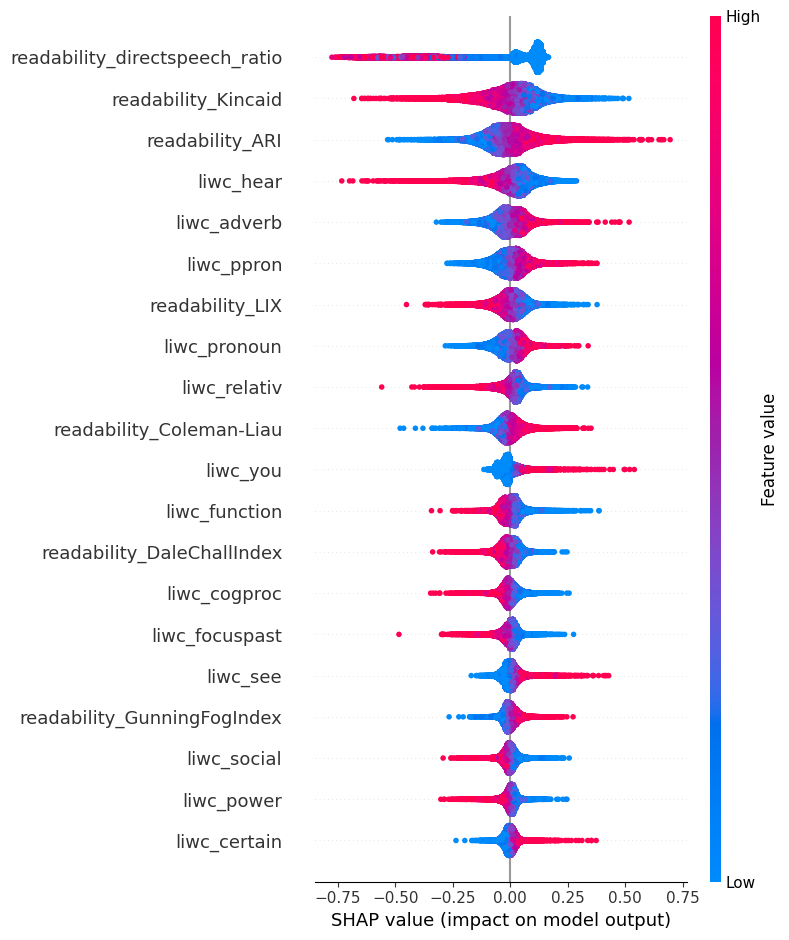

In [45]:
shap.summary_plot(results_shap['ISOT']['shap_values'], feature_names=results_shap['ISOT']['features'])

## Explainability with feature sets

In [48]:
from itertools import repeat, chain
revert_dict = lambda d: dict(chain(*[zip(val, repeat(key)) for key, val in d.items()]))

feature_singular_sets = {
    'Moral' : MORAL_FEATURES,
    'ReadabilityGrades' : READABILITY_GRADE_FEATURES,
    'ReadabilitySentenceInfo' : READABILITY_SENTENCEINFO_FEATURES,
    'ReadabilitySentenceBegininng' : READABILITY_SENTENCEBEGINNING_FEATURES,
    'ReadabilityWordUsage' : READABILITY_WORDUSAGE_FEATURES,
    'Sentiment' : SENTIMENT_FEATURES,
    'LIWCLinguistic' : LIWC_LINGUISTIC_FEATURES,
    'LIWCAffectiveProcesses' : LIWC_AFFECTIVEPROCESSES_FEATURES,
    'LIWCSocialProcesses' : LIWC_SOCIALPROCESSES_FEATURES,
    'LIWCCognitiveProcesses' : LIWC_COGNITIVEPROCESSES_FEATURES,
    'LIWCPerceptualProcesses' : LIWC_PERCEPTUALPROCESSES_FEATURES,
    'LIWCBiologicalProcesses' : LIWC_BIOLOGICALPROCESSES_FEATURES,
    'LIWCDrives' : LIWC_DRIVES_FEATURES,
    'LIWCTimeOrientation' : LIWC_TIMEORIENTATION_FEATURES,
    'LIWCRelativity' : LIWC_RELATIVITY_FEATURES,
    'LIWCPersonalConcerns' : LIWC_PERSONALCONCERNS_FEATURES,
    'LIWCInformalLanguage' : LIWC_INFORMALLANGUAGE_FEATURES,
}

def grouped_shap(shap_vals, features, groups):
    groupmap = revert_dict(groups)
    shap_Tdf = pd.DataFrame(shap_vals, columns=pd.Index(features, name='features')).T
    shap_Tdf['group'] = shap_Tdf.reset_index().features.map(groupmap).values
    shap_grouped = shap_Tdf.groupby('group').sum().T
    return shap_grouped

maptype = revert_dict(feature_singular_sets)

In [57]:
shap_type = grouped_shap(results_shap['FakeNewsKaggle']['shap_values'].values, results_shap['FakeNewsKaggle']['features'], feature_singular_sets)

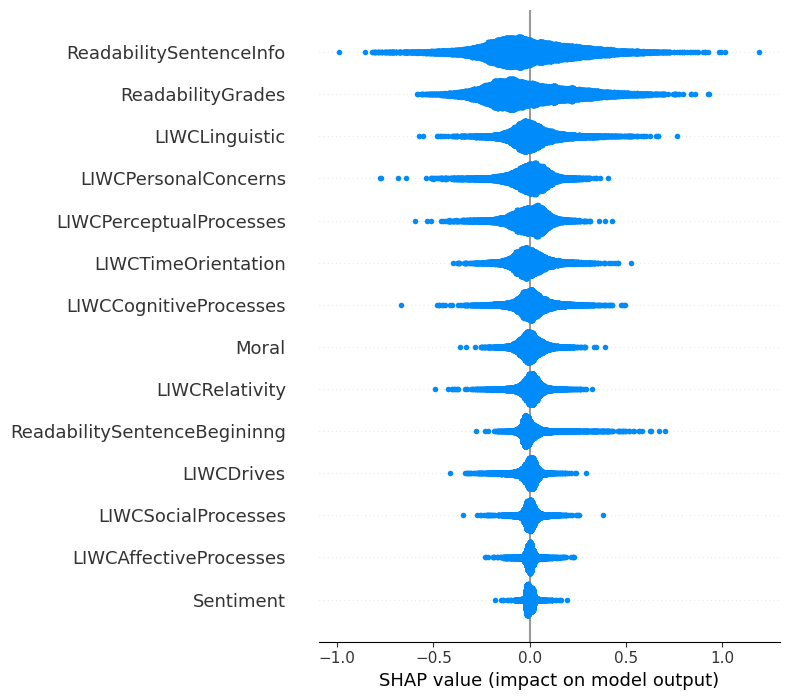

In [58]:
shap.summary_plot(shap_type.values, features=shap_type.columns)